# Practical Deep Learning Workshop 2021
## Assignment 2 - Embeddings
 
### Authors:
 
1.   Naor Kolet 205533060
2.   Chen Doytshman 205644941

# 0. Imports

In [37]:
import pandas as pd
import numpy as np
 
# TensorFlow
from tensorflow.keras.layers import Input, Embedding,Flatten, Concatenate,Dropout
from tensorflow.keras.layers import BatchNormalization, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import cpu_count

SEED = 42
%matplotlib inline

In [2]:
# random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
import py7zr

files = [f for f in os.listdir('input') if f.endswith('7z')]
for file in tqdm(files):
    with py7zr.SevenZipFile(f'input/{file}') as zf:
        zf.extractall('input')
        os.remove(f'input/{file}')

In [7]:
os.listdir('input')

['holidays_events.csv',
 'items.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

### 1.2 Data Load

In [8]:
train = pd.read_csv('input/train.csv')
train.set_index('id', inplace=True)
train

/home/chendoy/.conda/envs/tf-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...
125497035,2017-08-15,54,2089339,4.0,False
125497036,2017-08-15,54,2106464,1.0,True
125497037,2017-08-15,54,2110456,192.0,False


In [9]:
stores = pd.read_csv('input/stores.csv')#, index_col='store_nbr')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
items = pd.read_csv('input/items.csv')#, index_col='item_nbr')
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [11]:
trans = pd.read_csv('input/transactions.csv')
trans

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [12]:
holidays = pd.read_csv('input/holidays_events.csv')
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [13]:
oil = pd.read_csv('input/oil.csv', index_col='date')
oil

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [14]:
test = pd.read_csv('input/test.csv')
test

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
...,...,...,...,...,...
3370459,128867499,2017-08-31,54,2132163,False
3370460,128867500,2017-08-31,54,2132318,False
3370461,128867501,2017-08-31,54,2132945,False
3370462,128867502,2017-08-31,54,2132957,False


In [15]:
def preprocess(df):
    df.onpromotion.fillna(False, inplace=True)

In [16]:
preprocess(train)

In [17]:
preprocess(test)

## b. Solid Benchmark

In [2]:
def split_x_y(df=None, load_name=None, has_y=True):
    y = None
    if df:
        x = x[['store_nbr', 'item_nbr', 'onpromotion']].values
        joblib.dump(x, f'objects/{load_name}_x.sav')
        if has_y:
            y = train['unit_sales'].values
            joblib.dump(y, f'objects/{load_name}_y.sav')
    else:
        x = joblib.load(f'objects/{load_name}_x.sav')
        if has_y:
            y = joblib.load(f'objects/{load_name}_y.sav')
    
    if has_y:
        return x, y
    return x

In [3]:
train_x, train_y = split_x_y(load_name='train')

In [14]:
del train

NameError: name 'train' is not defined

In [ ]:
train_x.shape, train_y.shape

In [4]:
use_saved = True
rfr_path = 'models/rfr.sav'

if use_saved:
    rfr = joblib.load(rfr_path)
else:
    rfr = RandomForestRegressor(random_state=SEED, verbose=1, n_jobs=cpu_count())
    rfr.fit(train_x, train_y)

In [ ]:
test_x = test[['store_nbr', 'item_nbr', 'onpromotion']].values
test_x

In [19]:
rfr.score(train_x, train_y)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  6.1min finished


0.39961251024165234

In [ ]:
train_y_pred = rfr.predict(train_x)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


In [39]:
train_y_pred

array([  3.4287254 ,   5.26510413,   6.9765492 , ..., 396.3268911 ,
        22.18955333,   1.76479019])

In [ ]:
train_mae = mean_absolute_error(train_y, train_y_pred, squared=False)
train_mae

In [24]:
sub = pd.read_csv('input/sample_submission.csv')
sub.set_index('id', inplace=True)

In [25]:
sub

,unit_sales
id,
125497040,0
125497041,0
125497042,0
125497043,0
125497044,0
...,...
128867499,0
128867500,0
128867501,0


In [26]:
sub['unit_sales'] = rfr.predict(test_x)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.5s finished


In [34]:
sub[sub['unit_sales'] < 0] = 0

In [35]:
sub.to_csv('results/rfr.csv')

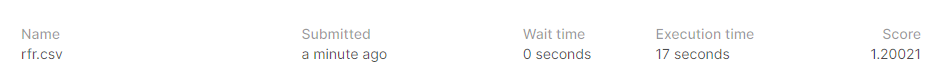

## c. Preprocessing Steps to Create an Embedding 

In [18]:
store_enc = LabelEncoder().fit(stores.store_nbr)
item_enc = LabelEncoder().fit(items.item_nbr)
prom_enc = LabelEncoder().fit([True, False])

In [19]:
def encoder(df):
    df.store_nbr = store_enc.transform(df.store_nbr)
    df.item_nbr = item_enc.transform(df.item_nbr)
    df.onpromotion = prom_enc.transform(df.onpromotion)

In [20]:
encoder(train)
train

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
0,2013-01-01,24,4,7.0,0
1,2013-01-01,24,5,1.0,0
2,2013-01-01,24,6,2.0,0
3,2013-01-01,24,13,1.0,0
4,2013-01-01,24,17,1.0,0
...,...,...,...,...,...
125497035,2017-08-15,53,3990,4.0,0
125497036,2017-08-15,53,3998,1.0,1
125497037,2017-08-15,53,4003,192.0,0


## d. Predicting the target using only the features embeddings 

In [21]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [22]:
def train_model(model_gen, args=None, batch_size=8192, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
    global train
    
    if args:
        train, val = args
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
            
        history = model_gen().fit(x=[train.store_nbr, train.item_nbr, train.onpromotion],
                    y=train.unit_sales,
                    batch_size=batch_size,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=callbacks
                    )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')

    # Generate generalization metrics
#     scores = model.evaluate(val[0], val[1], verbose=0)
#     score1 = f'{scores[1]:.2f}' if model.metrics_names[1] != 'acc' else f'{100*scores[1]:.2f}%'
#     print(f'\nScore on validation: {model.metrics_names[0]} of {scores[0]:.2f} ; {model.metrics_names[1]} of {score1}')
    print("")

    
    return model, history

In [23]:
def init_model_v1(n_factors=5):
    store_in = Input(shape=(1,), dtype='int64', name='store_in')
    s = Embedding(len(store_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(store_in)
    s = Flatten()(s)
    item_in = Input(shape=(1,), dtype='int64', name='item_in')
    i = Embedding(len(item_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(item_in)
    i = Flatten()(i)
    prom_in = Input(shape=(1,), dtype='int64', name='prom_in')
    p = Embedding(len(prom_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(prom_in)
    p = Flatten()(p)

    def create_bias(inp, n_in):
        X = Embedding(n_in, 1, input_length=1)(inp)
        return Flatten()(X)


    sb = create_bias(store_in, len(store_enc.classes_))
    ib = create_bias(item_in, len(item_enc.classes_))
    pb = create_bias(prom_in, len(prom_enc.classes_))

    X = Concatenate()([s, i, p, sb, ib, pb])
    X = BatchNormalization()(X)
    X = Dense(32,activation='relu')(X)
    X = Dense(16,activation='relu')(X)
    X = Dropout(0.4)(X)
    X = BatchNormalization()(X)
    X = Dense(16,activation='relu')(X)
    X = Dense(1,activation='relu')(X)

    model = Model([store_in, item_in, prom_in], X)
    model.compile(Adam(0.001), loss='mse', metrics=['mae'])
    
    return model

In [24]:
init_model_v1().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
prom_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         270         store_in[0][0]                   
______________________________________________________________________________________________

In [26]:
model_v1, history_v1 = train_model(init_model_v1, use_saved=False)

Epoch 1/20


/home/chendoy/.conda/envs/tf-env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


10724/10724 [==============================] - 142s 13ms/step - loss: 303.2378 - mae: 4.9550 - val_loss: 612.7449 - val_mae: 6.0107 - lr: 0.0010
Epoch 2/20
10724/10724 [==============================] - 141s 13ms/step - loss: 290.4782 - mae: 4.7323 - val_loss: 615.9636 - val_mae: 6.1839 - lr: 0.0010
Epoch 3/20
10724/10724 [==============================] - 140s 13ms/step - loss: 287.8271 - mae: 4.6908 - val_loss: 620.7961 - val_mae: 6.7637 - lr: 0.0010
Epoch 4/20
10724/10724 [==============================] - ETA: 0s - loss: 286.4701 - mae: 4.6706
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10724/10724 [==============================] - 141s 13ms/step - loss: 286.4701 - mae: 4.6706 - val_loss: 627.1859 - val_mae: 7.5764 - lr: 0.0010
Epoch 5/20
10724/10724 [==============================] - 140s 13ms/step - loss: 283.9471 - mae: 4.6291 - val_loss: 633.4865 - val_mae: 7.7776 - lr: 5.0000e-04
Epoch 00005: early stopping



In [30]:
def visualize_perf(h):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(f'Model performance over epochs')

    for k in ['loss', 'val_loss']:
        ax[0].plot(h[k])
        ax[0].legend(['train_loss', 'val_loss'])
        ax[0].margins(0.02)
        ax[0].set_title(f'Loss')

    for k in ['mae', 'val_mae']:
        ax[1].plot(h[k])
        ax[1].legend(['train_mae', 'val_mae'])
        ax[1].margins(0.02)
        ax[1].set_title(f'MAE')

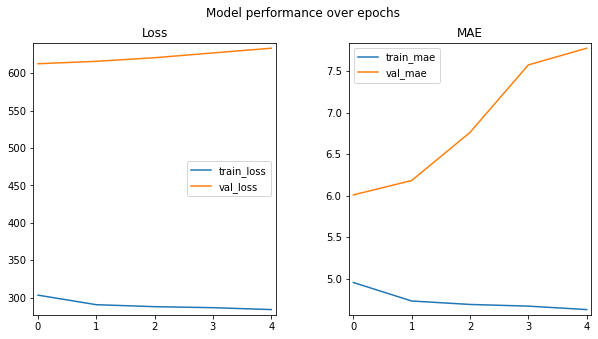

In [31]:
visualize_perf(history_v1)

## e. Adding more features and a time-series approach

Now we will add more features we find relevant for predicting ```unit_sales``` in addition to the embedding from previous trial. In addition, we will use LSTM network to better model the time series part of the problem.

In [28]:
def prepare_data_lstm():
    

In [34]:
def init_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

    return model

In [38]:
lstm_model = init_lstm_model((2,3)) # should be trainX or something here
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


## f. Interesting insights of embeddings

## g. Using embeddings as a “feature extractor” for classical ML

In [41]:
from sklearn.linear_model import LogisticRegression

# ...